In [137]:
import gym
import gym_chess
from gym_chess.alphazero import MoveEncoding
import numpy as np
import random
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
import tensorflow as tf

In [138]:
env = gym.make("Chess-v0")
env = MoveEncoding(env)
INPUT_DIM = 8*8
OUTPUT_DIM = 8*8*73

In [139]:
class DQNAgent:
    def __init__(self,num_episodes,avg_num_episodes,learning_rate = 0.1,discount_rate = 0.99):
#         self.exploration_rate = 1
        self.min_exploration_rate = 0.01
        self.max_exploration_rate = 1
        self.exploration_decay_rate = 0.001
        self.num_episodes = num_episodes
#         self.learning_rate = learning_rate
#         self.discount_rate = discount_rate
        self.avg_num_episodes = avg_num_episodes
        self.reward = 1
        self.gamma = 0.099
        self.exploration_rate = 1
        self.rewards_all_episodes = []
        self.results = []
        self.times_all_episodes = []
        self.time_results = []
        self.model = self.build_model()
        self.opt = tf.optimizers.SGD(0.01)
        
    def calculateAvgReward(self):
        # Calculate and print the average reward per thousand episodes

        rewards_per_thousand_episodes = np.split(np.array(self.rewards_all_episodes),self.num_episodes/self.avg_num_episodes)
        count = self.avg_num_episodes

#         print("********Average reward per "+str(self.avg_num_episodes)+" episodes********\n")
        for r in rewards_per_thousand_episodes:
            avg_per_thousand_episode = str(sum(r/self.avg_num_episodes))
#             print(count, ": ", avg_per_thousand_episode)
            self.results.append({"episode":count,"reward":avg_per_thousand_episode})
            count += self.avg_num_episodes
            
    def calculateAvgTime(self):

        times_per_thousand_episodes = np.split(np.array(self.times_all_episodes),self.num_episodes/self.avg_num_episodes)
        count = self.avg_num_episodes

#         print("********Average time in seconds per "+str(self.avg_num_episodes)+" episodes********\n")
        for r in times_per_thousand_episodes:
            avg_per_thousand_episode = sum(r/self.avg_num_episodes)
            avg_sec_per_thousand_episode = avg_per_thousand_episode % 60
#             print(count, ": ", avg_sec_per_thousand_episode)
            self.time_results.append({"episode":count,"seconds":avg_sec_per_thousand_episode})
            count += self.avg_num_episodes
            
    def createLinePlotForRewards(self):
        df = pd.DataFrame(self.results)
        fig, ax1 = plt.subplots(figsize=(12, 8))
        sns.lineplot(data=df, x="episode", y="reward", ax=ax1, ci=None)
        ax1.set_ylabel('Rewards',fontsize=13)
        ax1.set_xlabel('Episodes',fontsize=13)
        ax1.set_title("Average reward per "+str(self.avg_num_episodes)+" episodes",fontsize=16)
        
    def createLinePlotForDuration(self):
        df = pd.DataFrame(self.time_results)
        fig, ax1 = plt.subplots(figsize=(12, 8))
        sns.lineplot(data=df, x="episode", y="seconds", ax=ax1, ci=None)
        ax1.set_ylabel('Seconds',fontsize=13)
        ax1.set_xlabel('Episodes',fontsize=13)
        ax1.set_title("Average time per "+str(self.avg_num_episodes)+" episodes",fontsize=16)
        
        
    def build_model(self):
        inputs = tf.keras.layers.Input(INPUT_DIM)
        net = tf.keras.layers.Dense(64,activation='sigmoid')(inputs)
        net = tf.keras.layers.Dense(64,activation='sigmoid')(net)
        outputs = tf.keras.layers.Dense(OUTPUT_DIM)(net)
        model = tf.keras.Model(inputs,outputs)
        return model
    
    def loss_grads(self,state, target):
        with tf.GradientTape(persistent=True) as tape:
            pred = self.model(state)
            loss = tf.reduce_mean(tf.square(pred-target))
        grads = tape.gradient(loss,self.model.trainable_variables)
        return loss, grads
    
    def act(self,state, legal_moves):
        self.exploration_rate_threshold = random.uniform(0, 1)
        if self.exploration_rate_threshold >= self.exploration_rate:
            action = random.choice(list(env.legal_actions)) # Exploration
        else:
            act_values = self.model.predict(state)
            action = np.argmax(set(act_values[0])) # Exploitation
            if action not in env.legal_actions:
                action = random.choice(list(env.legal_actions)) # Exploration
#         if self.exploration_rate > self.min_exploration: 
#             self.exploration_rate *= 0.99 
        return action  # returns action
    
    def getMoves(self,legal_moves):
    
        legal_moves = list(legal_moves)

        result = []

        for move in legal_moves:
#             try:
            result.append(env.encode(move))
#             except:
#                 result.append(0)

        while len(result) < INPUT_DIM:
            result.append(0)
        
        while len(result) > INPUT_DIM:
            result.pop()
    #     print('result: ',result)
        return np.array([result])

    def isLegalAction(self,action,legal_actions):
        return True if action in legal_actions else False
    
    def play(self):
        for episode in range(num_episodes):
            
            finished = False
            rewards_current_episode = 0
            start_time = time.time()
            state = env.reset()
            
            clear_output(wait=True)
            print("*****EPISODE ", episode+1, "*****\n\n\n\n")

            while not finished:
                if state.is_checkmate() or state.is_stalemate() or state.is_insufficient_material() or \
                    state.is_game_over() or state.can_claim_threefold_repetition() or state.can_claim_fifty_moves() or \
                    state.can_claim_draw() or state.is_fivefold_repetition() or state.is_seventyfive_moves():
                    finished = True

                if finished:
                    break
                else:
                    prev_state = self.getMoves(state.legal_moves)

                    current_action = self.act(prev_state,state.legal_moves)

                    new_state, reward, done, info = env.step(current_action)


                    curr_state = self.getMoves(new_state.legal_moves)
                    
                    try:
                        #  print('curr_state: ', curr_state)

                        prev_pred = self.model(prev_state)
                        prev_action = tf.argmax(prev_pred)

            #             print('prev_action', prev_action)

                        curr_pred = self.model(curr_state)

                        curr_value = tf.reduce_sum(curr_pred)


                        target = prev_pred.numpy()
                        target[prev_action] = reward + self.gamma * curr_value

                        self.gamma *= 0.1

                        loss,grads = self.loss_grads(prev_state, target)
                        self.opt.apply_gradients(zip(grads,self.model.trainable_variables))
                    except:
                        print('prev_state.shape: ',prev_state.shape)
                        print('curr_state.shape: ',curr_state.shape)

                    state = new_state
                    rewards_current_episode += reward
                    
            end_time = time.time()
            time_lapsed = end_time - start_time
            self.times_all_episodes.append(time_lapsed)
            self.rewards_all_episodes.append(rewards_current_episode)
            
            # Exploration rate decay
            self.exploration_rate = self.min_exploration_rate + \
                (self.max_exploration_rate - self.min_exploration_rate) * np.exp(-self.exploration_decay_rate*episode)
            
        self.calculateAvgReward()
        self.createLinePlotForRewards()
        
        self.calculateAvgTime()
        self.createLinePlotForDuration()

In [140]:
num_episodes = 10000
avg_num_episodes = round(num_episodes/10)
agent = DQNAgent(num_episodes,avg_num_episodes)

*****EPISODE  10000 *****






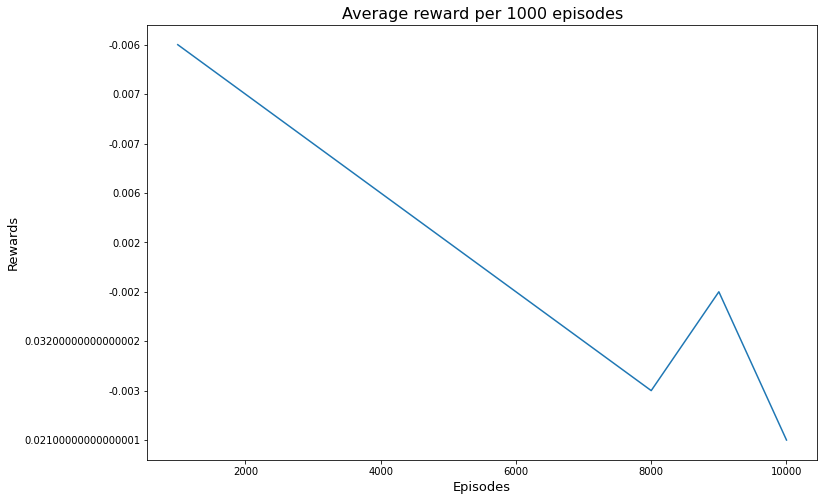

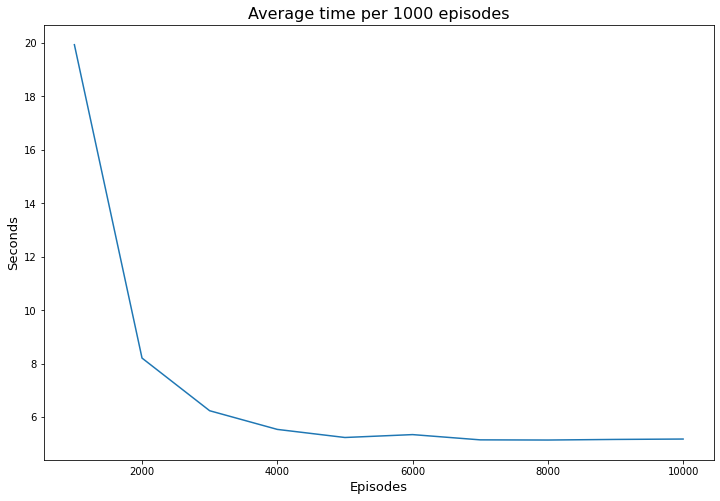

In [141]:
agent.play()